##### System Libraries

In [1]:
import os
import subprocess
import logging
import re
import copy
import time
import math
import json
import pickle

##### Required Libraries

In [2]:
try:
    import numpy as np
except ModuleNotFoundError:
    os.system('pip install numpy')
    import numpy as np
try:
    import scapy
except ModuleNotFoundError:
    os.system('pip install scapy')
    import scapy
try:
    import tqdm
except ModuleNotFoundError:
    os.system('pip install tqdm')
    import tqdm
try:
    import requests
except ModuleNotFoundError:
    os.system('pip install requests')
    import requests
try:
    import pandas as pd
except ModuleNotFoundError:
    os.system('pip install pandas')
    import pandas as pd
try:
    import sklearn
except ModuleNotFoundError:
    os.system('pip install scikit-learn')
    import sklearn
try:
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')
    import matplotlib
    
logging.getLogger("requests").setLevel(logging.INFO)
logging.getLogger("urllib3").setLevel(logging.INFO)

import scapy.plist
from scapy.all import rdpcap
from tqdm import trange,tqdm

### Analyzer

#### Minor Function Breakdowns
---
##### Generate_Logger
Generates a logger with default parameters for logging critical components and debugging, default mode is INFO, for debugging change it to DEBUG
##### Generate Self IPs
Generates a list of IPs assigned to current device according to a protocol list. Uses 'ipconfig' from command prompt to get info.
##### List Initializer [V2]
Helper function to shorten and simplify initializing and re-initializing lists with values. Avoids creating lists within lists if used correctly.
##### Read JSON [V2] #deprecated
Reads a JSON file from the provided directory with the filename.(extension). Can work without the filename extension, will throw error if file doesn't exist.
##### Read List [V2] #deprecated
Reads a PKL file from the provided directory with the filename.(extension). Can work without the filename extension, will throw error if file doesn't exist.
##### Write JSON [V2]
Creates a json file with the dictionary at the directory. Can work without filename extenstion.
##### Write List [V2]
Creates a pkl file with the dictionary at the directory. Can work without filename extenstion.
##### Remove Reserved IPs
Removes IPs that belong in the reserved ranges from the provided list. '192.168.' range is excluded.
##### Calc Trans time
Calculates the capture time of the pcap data
##### PCAP_Input [1.5]
Takes a PCAP file as input and stores it internally for later use
##### Generate Unique IPs [V2]
Generates a list of unique IPs found in the PCAP data (excluding self IPs), if already generated and saved, loads it. Can be forced.
##### Calc Flow
Calculates the total flow of data in bytes per IP, download and upload in the PCAP data
##### Calc Flow Rate
Calculates the flow rate per IP, download and upload
##### Query IP
Queries the ip-api website for a single ip, waits for the response, and returns it back. Primarily a helper function.
##### Query IPs [V2]
Requests IP information from ip-api through requests, and stores the received data in a list, saves the list so we dont have to query every single time we run the program, saving time. Can be forced.
##### Generate Summary [V1.1]
Summarizes the data in a neater form from queried data for the user
##### Generate Dataset [WIP]
Should generate a dataset for use in clustering
##### Trace IPs
Traces the IPs and returns the output

Known Bugs

Will throw a 'Flow' KeyError if the queried_data and unique_ips dont match

To-Do

fix the generate dataset data_in deepcopy bug properly

get torrenting pcap data

In [48]:

class Analyzer:
    if True:
        #Initialization of the logger, have to do it here, else it breaks stuff
        logger=logging.getLogger
        stored_logger_level=[logging.INFO]
        stored_self_ip_protocol_list=["IPv4","IPv6"]

        stored_pcap_data=[]
        stored_path=[]
        stored_directory=[]
        
        stored_transmission_time=[]
        
        stored_self_ips=[]
        stored_unique_ips=[]
        stored_blocked_ips=[]

        stored_queried_data=[]
        stored_flow=[]
        stored_protocol_dict={'1':'ICMP','2':'IGMP','3':'GGP','4':'IPv4','5':'Stream','6':'TCP','17':'UDP'}
        stored_port_dict={'53':'DNS','80':'HTTP','137':'NetBIOS','443':'HTTPS','1900':'SSDP','4070':'Amzn EDot2Sptfy','5222':'XMPP'}
        
        stored_df=pd.DataFrame()
        
    def __init__(self,path,protocol_list=stored_self_ip_protocol_list,
                 query=True,query_amount=45,remove_reserved=True,forced=False,forced_query=False,verbose=True,replace=True):
        if True:
            self.logger=self.Generate_Logger(filename='AnalysisCore.log')
            logging.getLogger("requests").setLevel(logging.INFO)
            self.Generate_Self_IPs(protocol_list=protocol_list)
            self.PCAP_Input(path)
            self.Calc_Trans_Time()
            self.Generate_Unique_IPs(remove_reserved=remove_reserved,forced=forced,verbose=verbose)
            self.Analyze_Flow(forced=forced,verbose=verbose)
            if query==True:
                self.Query_IPs(amount=query_amount,forced=forced_query,verbose=verbose)
            self.Generate_Dataset(forced=forced,verbose=verbose,replace=replace)
    def Generate_Logger(self,filename='default_logger_name.log'): 
        logging.basicConfig(filename=filename,format='%(asctime)s - %(levelname)s: %(message)s',
                            datefmt='%Y-%m-%d %H:%M:%S',filemode='w',level=self.stored_logger_level[0])
        logger=logging.getLogger()
        logger.debug('Logger initialized.')
        return logger
    def Generate_Self_IPs(self,protocol_list=stored_self_ip_protocol_list):
        self.logger.info("Generating self IPs with protocols, "+str(protocol_list))
        self_ips=[]
        process=subprocess.Popen(['ipconfig'],stdout=subprocess.PIPE,text=True,shell=True)
        for line in process.stdout:
            for protocol in protocol_list:
                if re.search(protocol,line.strip()):
                    self_ips.append(line.strip()[line.strip().find(':')+2:])
        self.List_Initializer(self.stored_self_ips,self_ips)
        self.logger.debug('Stored self IPs in stored_self_ips '+str(self_ips))
        return self_ips
    def List_Initializer(self,input_list,input_param):
        if isinstance(input_param,list) or isinstance(input_param,scapy.plist.PacketList):
            input_list.clear()
            for item in input_param:
                input_list.append(item)
        else:
            input_list.clear()
            input_list.append(input_param)

    def Read_JSON(self,directory,filename): #deprecated
        name, ext=os.path.splitext(filename)
        if os.path.exists(f'{directory}/{name}.json'): #if the file exists,
            self.logger.debug(f'Reading JSON from {directory}/{filename}') 
            with open(f'{directory}/{name}.json') as file: #then open it
                data=json.load(file) #save it
                return data #return it
        else:
            self.logger.error(f'Trying to open {filename} as JSON')
    def Read_List(self,directory,filename): #deprecated
        name, ext=os.path.splitext(filename)
        if os.path.exists(f'{directory}/{name}.pkl'): #if the file exists,
            self.logger.debug(f'Reading PKL from {directory}/{filename}')
            with open(f'{directory}/{name}.pkl','rb') as file: #then open it
                data=pickle.load(file) #save it
                return data #return it
        else:
            self.logger.error(f'Trying to open {filename} as PKL')
    def Write_JSON(self,dictionary,directory,filename):
        name, ext=os.path.splitext(filename)
        if ext!='.json': #make sure we are writing a json
            if ext!='':
                self.logger.error(f'Trying to write {filename} as {ext} is not JSON')
                return
        os.makedirs(directory,exist_ok=True) #make sure the directory exists, if it does not, create it
        self.logger.debug(f'Writing JSON at {directory}/{name}.json')
        with open(f'{directory}/{name.replace(':','')}.json','w') as file:  #create a file
            json.dump(dictionary,file,indent=4) #dump the dictionary in the file
    def Write_List(self,list,directory,filename):
        name, ext=os.path.splitext(filename)
        if ext!='.pkl': #make sure we are writing a pkl
            if ext!='':
                self.logger.error(f'Trying to write {filename} as {ext} is not PKL')
                return
        os.makedirs(directory,exist_ok=True) #make sure the directory exists, if it does not, create it
        self.logger.debug(f'Writing PKL at {directory}/{name}.pkl')
        with open(f'{directory}/{name.replace(':','')}.pkl','wb') as file:  #create a file
            pickle.dump(list,file) #dump the list in the file

    def Remove_Reserved_IPs(self,ips):
        self.logger.debug(f'Removing reserved IP ranges from list')
        dot=re.escape('.')
        patterns=[f'0{dot}0{dot}0{dot}0', f'10{dot}', f'127{dot}', f'169{dot}254{dot}', f'192{dot}0{dot}0{dot}', f'192{dot}0{dot}2{dot}', f'192{dot}18{dot}', f'192{dot}19{dot}',f'192{dot}51{dot}100{dot}', f'192{dot}88{dot}99{dot}', f'203{dot}0{dot}113{dot}', f'255{dot}', f'256{dot}']+[f'100{dot}{x}{dot}' for x in range(64,128)]+[f'172{dot}{x}{dot}' for x in range(16,32)]+[f'{x}{dot}' for x in range(224,240)]
        #self.logger.debug(patterns)
        temp=[]
        for ip in ips:
            for pattern in patterns:
                if re.match(pattern,ip):
                    self.logger.debug(f'Pruning {ip} with {pattern}')
                    temp.append(ip)
        for ip in ips:
            if re.search('::',ip):
                self.logger.debug(f'Pruning IPv6 IP {ip}')
                temp.append(ip)
        for temp_ip in temp:
            ips.remove(temp_ip)
        self.logger.info(f'Removed {temp}')
        return ips        
    def Calc_Trans_Time(self,pcap_data=stored_pcap_data):
        self.logger.debug(f'Calculating transmission time.')
        time=math.floor(pcap_data[-1].time-pcap_data[0].time)
        self.List_Initializer(self.stored_transmission_time,time)
        return time

    def PCAP_Input(self,path):
        directory=path[:path.find('.')]
        self.List_Initializer(self.stored_path,path)
        self.List_Initializer(self.stored_directory,directory)
        file_size=math.ceil(os.path.getsize(path)/math.pow(1024,2))
        print(f'Reading PCAP Data. [{file_size} MB]')
        self.logger.info(f'Reading PCAP data [{file_size} MB] from path, "{path}"')
        pcap_data=rdpcap(path)
        self.List_Initializer(self.stored_pcap_data,pcap_data)
        self.logger.debug(f'Stored {path} data in stored_pcap_data.')
        return pcap_data

    def Generate_Unique_IPs(self,pcap_data=stored_pcap_data,self_ips=stored_self_ips,remove_reserved=True,verbose=True,forced=False,save=True):
        unique_ips=[]
        directory=self.stored_directory[0]
        filename='unique_ips.pkl'
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing unique_ips data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(self.stored_unique_ips,read_list)
                if verbose:
                    print(f'Found unique_ips data. [{len(read_list)}]')
                return read_list
            else:
                data_not_found=True
        if (forced or data_not_found): #generate data
            self.logger.info('Extracting Unique IPs from PCAP Data.')
            blocked_ips=self_ips.copy()
            packets=pcap_data
            if verbose:
                for packet in tqdm(packets,desc='Analyzing packets for unique IPs'):
                    flag=0
                    try:
                        for ip in blocked_ips:
                            if packet.payload.dst==ip:
                                flag=1
                        if flag==0:
                            blocked_ips.append(packet.payload.dst)
                            unique_ips.append(packet.payload.dst)
                    except AttributeError:
                        broadcast_temp='256.256.256.256'
                        for ip in blocked_ips:
                            if ip==broadcast_temp:
                                flag=1
                        if flag==0:
                            blocked_ips.append(broadcast_temp)
                            unique_ips.append(broadcast_temp)
            else:
                for packet in packets:
                    flag=0
                    try:
                        for ip in blocked_ips:
                            if packet.payload.dst==ip:
                                flag=1
                        if flag==0:
                            blocked_ips.append(packet.payload.dst)
                            unique_ips.append(packet.payload.dst)
                    except AttributeError:
                        broadcast_temp='256.256.256.256'
                        for ip in blocked_ips:
                            if ip==broadcast_temp:
                                flag=1
                        if flag==0:
                            blocked_ips.append(broadcast_temp)
                            unique_ips.append(broadcast_temp)
            if remove_reserved==True:
                self.Remove_Reserved_IPs(unique_ips)
            if save==True:
                self.Write_List(unique_ips,directory,'unique_ips')
            self.List_Initializer(self.stored_unique_ips,unique_ips)
        self.logger.debug('Stored unique IPs in stored_unique_ips.')
        return unique_ips
    def Analyze_Flow(self,pcap_data=stored_pcap_data,forced=False,verbose=True):
        directory=self.stored_directory[0]
        filename='flow.pkl'
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing flow_rate data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(self.stored_flow,read_list)
                if verbose:
                    print(f'Found analyzed flow data. [{len(read_list)}]')
                return read_list
            else:
                data_not_found=True
        if (forced or data_not_found):
            analyzed_flow=[]
            trans_time=self.stored_transmission_time[0]
            self.logger.info(f'Calculating flow [{len(pcap_data)}]')
            if verbose:
                print(f'Analyzing packets. [{len(pcap_data)}]')
            
            for ip in self.Generate_Unique_IPs(remove_reserved=True,verbose=False,save=False,forced=True): #initialize with all the unique ips except self ips
                analyzed_flow.append([ip,0,0,0,0,[],[],[]]) #IP, Down Bytes, Up Bytes, Down Packets, Up Packets, Used Protocols, S Ports, D Ports
            
            for packet in pcap_data: #for every packet, the analysis of the flow of data happens in this loop
                for self_ip in self.stored_self_ips: #for every self ip
                    try:
                        if packet.payload.dst==self_ip: #check if payload destination is self ip (download)
                            for flow_data in analyzed_flow: #for every unique ip tuple
                                try:
                                    if flow_data[0]==packet.payload.src: #if the payload source matches with the unique ip
                                        flow_data[1]+=packet.payload.len-14 #add the payload len to stored downloaded bytes
                                        flow_data[3]+=1 #count the number of packets downloaded
                                        if packet.payload.proto not in flow_data[5]:
                                            flow_data[5].append(packet.payload.proto)
                                        if packet.payload.sport not in flow_data[6]:
                                            flow_data[6].append(packet.payload.sport)
                                        if packet.payload.dport not in flow_data[7]:
                                            flow_data[7].append(packet.payload.dport)
                                        break
                                except AttributeError:
                                    pass
                            break
                        else: #if the destination isnt a self ip, then it must be upload
                            for flow_data in analyzed_flow: #for every unique ip
                                try:
                                    if flow_data[0]==packet.payload.dst: #if the payload destination matches with the unique ip
                                        flow_data[2]+=packet.payload.len-14 #add the payload len to stored uploaded bytes
                                        flow_data[4]+=1 #count the number of packets uploaded
                                        if packet.payload.proto not in flow_data[5]:
                                            flow_data[5].append(packet.payload.proto)
                                        if packet.payload.sport not in flow_data[6]:
                                            flow_data[6].append(packet.payload.sport)
                                        if packet.payload.dport not in flow_data[7]:
                                            flow_data[7].append(packet.payload.dport)
                                        break
                                except AttributeError: #if removed, broadcast packets will throw errors
                                    pass
                    except AttributeError:
                        pass
            for flow_data in analyzed_flow: #2nd iteration of analysis happens here
                dl_bytes=flow_data[1]
                up_bytes=flow_data[2]
                dl_pkts=flow_data[3]
                up_pkts=flow_data[4]
                flow_data.append(math.trunc(float(dl_bytes)/trans_time*100)/100) #avg download speed in bytes/s
                flow_data.append(math.trunc(float(up_bytes)/trans_time*100)/100) #avg upload speed in bytes/s
                try:
                    down_psize=math.trunc(dl_bytes/dl_pkts*100)/100
                except ZeroDivisionError:
                    down_psize=0
                try:
                    up_psize=math.trunc(up_bytes/up_pkts*100)/100
                except ZeroDivisionError:
                    up_psize=0
                flow_data.append(down_psize)
                flow_data.append(up_psize)
            self.List_Initializer(self.stored_flow,analyzed_flow)
            directory=self.stored_directory[0]
            self.Write_List(analyzed_flow,directory,filename)
        self.logger.debug('Stored total flow in stored_flow')
        return analyzed_flow
    
    def Query_IP(self,ip):
        self.logger.debug(f'Querying for IP {ip}')
        response=requests.get(f"http://ip-api.com/json/{ip}")
        data=response.json()
        return data    
    def Query_IPs(self,ips=stored_unique_ips,amount=45,forced=False,verbose=True):
        queried_data=[]
        to_be_queried=ips.copy()
        directory=self.stored_directory[0]
        filename='queried_data.pkl'
        incomplete=False
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing query data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(queried_data,read_list)
                if len(read_list)<len(to_be_queried):
                    incomplete=True
                if verbose:
                    print(f'Found query data. [{len(queried_data)}]')
                    if incomplete:
                        print(f'Query data is incomplete. [{min(len(to_be_queried)-len(read_list),amount)}+{max(0,len(to_be_queried)-len(read_list)-amount)}]')
            else:
                data_not_found=True
        if (forced or incomplete or data_not_found):
            if incomplete: #if incomplete, prune
                self.logger.debug(f'Pruning IPs')
                prune=[]
                for query in queried_data: #for every queried IP
                    for ip in to_be_queried: #for every IP to be queried
                        if query[0]==ip: #check if the IP has already been queried
                            prune.append(ip) #add the IP to a pruning list
                            break
                for pruning_ip in prune: #prune the IPs
                    to_be_queried.remove(pruning_ip)
            self.logger.info(f'Querying IPs [{len(to_be_queried)}]')
            if verbose:
                for ip in tqdm(to_be_queried[:min(amount,45)],desc='Querying IPs'):
                    response=self.Query_IP(ip)
                    temp=[ip]
                    temp.append(response)
                    queried_data.append(temp)
            else:
                print(f'Query_IPs verbose=false incomplete')
            self.Write_List(queried_data,directory,filename)
        self.List_Initializer(self.stored_queried_data,queried_data)
        self.logger.debug('Stored queried data in stored_queried_data')
        
        return queried_data
    
    def Generate_Summary(self,data=stored_queried_data):
        self.logger.info(f'Summarizing data.')
        summarized=[]
        for query_data in data:
            temp={}
            query=query_data[1]
            if query['status']=='success':
                temp['Organization']=f"{query['as']}, {query['org']}, {query['isp']}"
                temp['Location']=f"{query['city']}, {query['regionName']}, {query['country']} | {query['lat']}, {query['lon']}"
                temp['IP']=f"{query['query']}"
            elif query['status']=='fail':
                temp['Location']=f'Unknown [Failed]'
                temp['Organization']=f'Unknown [Failed]'
                temp['IP']=f"{query['query']}"
            summarized.append(temp)
        self.logger.debug('Summarizing completed.')
        
        if self.stored_flow!=[]: #if there is flow data, add it to summary
            for summary in summarized:
                for flow_data in self.stored_flow:
                    if flow_data[0]==summary['IP']:
                        try:
                            down_psize=math.trunc(flow_data[1]/flow_data[3]*100)/100
                        except ZeroDivisionError:
                            down_psize=0
                        try:
                            up_psize=math.trunc(flow_data[2]/flow_data[4]*100)/100
                        except ZeroDivisionError:
                            up_psize=0
                        summary['Flow']=f'{flow_data[5]} byte/s Down, {flow_data[6]} byte/s Up. Packets, {flow_data[3]} Received, {flow_data[4]} Sent'
                        summary['Misc']=f'Average Packet Size {down_psize} Down, {up_psize} Up'
                            
        return summarized
    def Generate_Dataset(self,data_in=stored_flow,replace=True,forced=False,verbose=True):
        directory=self.stored_directory[0]
        filename='dataframe.csv'
        data_not_found=False
        data=copy.deepcopy(data_in)
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing dataframe at {directory}/{filename}')
                df=pd.read_csv(f'{directory}/{filename}')
                if verbose:
                    print(f'Found dataframe. [{len(df)}]')
            else:
                data_not_found=True
        if (forced or data_not_found):
            protocols=self.stored_protocol_dict
            ports=self.stored_port_dict
            self.logger.info(f'Generating dataset')
            if verbose:
                print(f'Generating Dataset [{len(data)}]')
            if replace:
                for flow_data in data:
                    protocol_data=flow_data[5]
                    sport_data=flow_data[6]
                    sport_prune=[]
                    dport_data=flow_data[7]
                    dport_prune=[]
                    for protocol in protocol_data:
                        if str(protocol) in protocols:
                            protocol_data[protocol_data.index(protocol)]=protocols.get(str(protocol))
                        else:
                            self.logger.error(f'Protocol {protocol} not found in dictionary')
                    for sport in sport_data:
                        if str(sport) in ports:
                            sport_data[sport_data.index(sport)]=ports.get(str(sport))
                        elif sport>=49152 and sport<=65535: #all the dynamic ports
                            if 'Dynamic' not in sport_data: #if a dynamic port doesnt already exist, make one, rest go in garbage
                                sport_data[sport_data.index(sport)]='Dynamic'
                            else:
                                sport_prune.append(sport) #add all the dynamic ports to a pruning list
                        elif sport>=27000 and sport<=27036: #steam ports
                            if 'Steam' not in sport_data:
                                sport_data[sport_data.index(sport)]='Steam'
                            else:
                                sport_prune.append(sport)
                        else:
                            self.logger.debug(f'Port {sport} not found in dictionary')
                    for dport in dport_data:
                        if str(dport) in ports:
                            dport_data[dport_data.index(dport)]=ports.get(str(dport))
                        elif dport>=49152 and dport<=65535: #all the dynamic ports
                            if 'Dynamic' not in dport_data: #if a dynamic port doesnt already exist, make one, rest go in garbage
                                dport_data[dport_data.index(dport)]='Dynamic'
                            else:
                                dport_prune.append(dport) #add all the dynamic ports to a pruning list
                        elif dport>=27000 and dport<=27036: #steam ports
                            if 'Steam' not in dport_data:
                                dport_data[dport_data.index(dport)]='Steam'
                            else:
                                sport_prune.append(dport)
                        else:
                            self.logger.debug(f'Port {dport} not found in dictionary')
                    for sport in sport_prune: #prune the ports
                        sport_data.remove(sport)
                    for dport in dport_prune: #prune the ports
                        dport_data.remove(dport)
            df=pd.DataFrame(data,columns=['IP Address','Bytes Dl','Bytes Up','Pkts Dl','Pkts Up','Protocol(s)','Source Ports','Destination Ports','Avg Dl B/s','Avg Up B/s','Avg Dl PSize','Avg Up PSize'])
            
            if self.stored_queried_data!=[]:
                summarized_data=self.Generate_Summary()
                for summary in summarized_data:
                    del summary['IP']
                    del summary['Flow']
                    del summary['Misc']
                q_df=pd.DataFrame(summarized_data)
                df=pd.concat([df,q_df],axis=1)
            
            df.drop('Source Ports',axis=1,inplace=True)
            
            df.to_csv(f'{directory}/{filename}',index=False)
        self.stored_df=df.copy()
        self.logger.debug(f'Stored dataframe in stored_dataframe')
        return df
        
        
    def Trace_IPs(self,ips=stored_unique_ips,amount=99,hops=20,timeout=1000):
        self.logger.info(f'Tracing IPs {ips[:amount]}')
        processes=[]
        for ip in ips[:amount]:
            processes.append(subprocess.Popen(["tracert","-h",str(hops),"-w",str(timeout),ip],
                                              stdout=subprocess.PIPE,text=True,shell=True))
        time.sleep(math.ceil(hops*(timeout/1000)*3.75*(1+amount*0.001)))
        outputs_temp=[]
        for process in processes:
            outputs_temp.append(process.stdout)
        output_cleaned=[]
        for output in outputs_temp:
            temp=[]
            for line in output:
                if line.strip()!='':
                    temp.append(line.strip())
            output_cleaned.append(temp)
        return output_cleaned
    
    def Analyze_Flow_Rate(self,pcap_data=stored_pcap_data,forced=False,verbose=True): #deprecated
        directory=self.stored_directory[0]
        filename='flow_rate.pkl'
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing flow_rate data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(self.stored_flow_rate,read_list)
                if verbose:
                    print(f'Found flow_rate data. [{len(read_list)}]')
                return read_list
            else:
                data_not_found=True
        if (forced or data_not_found):
            self.logger.info('Calculating flow rates')
            trans_time=self.stored_transmission_time[0]
            flow=self.Analyze_Flow(pcap_data)
            for ip_flow in flow:
                ip_flow[1]=math.trunc(float(ip_flow[1])/trans_time*100)/100
                ip_flow[2]=math.trunc(float(ip_flow[2])/trans_time*100)/100
            flow_rate=flow
            self.List_Initializer(self.stored_flow_rate,flow_rate)
            self.Write_List(flow_rate,self.stored_directory[0],'flow_rate')
        self.logger.debug('Stored flow rate in stored_flow_rate')
        return flow_rate
    def Query_Unique_IPs(self,unique_ips=stored_unique_ips,amount=20): #deprecated
        directory=self.stored_directory[0]
        if os.path.exists(f'{directory}/'):
            pass
        queried_unique_ips=[]
        to_be_queried=unique_ips.copy()
        
        self.logger.info(f'Querying unique IPs.')
        
        
        if len(self.stored_queried_ips)!=0: #if data already exists, then read it
            self.logger.debug(f'Found queried data. Pruning query list')
            for query in self.stored_queried_ips:   #prune the IPs to be queried
                for ip in to_be_queried:
                    try:
                        if query['query']==ip:
                            to_be_queried.remove(ip)
                    except KeyError:
                        pass
        if len(to_be_queried)!=0: #only if there are IPs to be queried, then query
            for ip in tqdm(to_be_queried[:min(amount,45)],desc='Querying IPs'):
                response=self.Query_IP(ip)
                queried_unique_ips.append(response)
                self.Write_JSON(response,self.stored_path[0][:self.stored_path[0].find('.')],response['query'])
        else:
            self.logger.info(f'All unique IPs are queried')
            print(f'All unique IPs are already queried')
            temp={'status':'Completed',
                  'amount':f'{len(self.stored_queried_ips)} IPs',
                  'time':f'{self.stored_transmission_time[0]} seconds'}
            self.Write_JSON(temp,self.stored_path[0][:self.stored_path[0].find('.')],'status')
        if len(self.stored_queried_ips)!=0: #if theres already data then append to it, else initialize it, if removed it will always overwrite data
            for query in queried_unique_ips:
                self.stored_queried_ips.append(query)
        else:
            self.List_Initializer(self.stored_queried_ips,queried_unique_ips)
        return queried_unique_ips

In [54]:
A=Analyzer('PCAP Data/30S-Down-Spo-Brow-Misc.pcap')

Reading PCAP Data. [7 MB]
Found unique_ips data. [29]
Found analyzed flow data. [29]
Found query data. [29]
Found dataframe. [29]


In [60]:
A.stored_df.sort_values('Avg Dl B/s',ascending=False)

,IP Address,Bytes Dl,Bytes Up,Pkts Dl,Pkts Up,Protocol(s),Destination Ports,Avg Dl B/s,Avg Up B/s,Avg Dl PSize,Avg Up PSize,Organization,Location
16,157.240.1.60,6162896,699448,5243,10856,"['UDP', 'TCP']","['HTTPS', 'Dynamic', 'XMPP']",205429.86,23314.93,1175.45,64.42,"AS32934 Facebook, Inc., Facebook, Inc., Facebo...","Kolkata, West Bengal, India | 22.5643, 88.3693"
27,57.144.143.32,101220,30552,103,256,['UDP'],"['HTTPS', 'Dynamic']",3374.00,1018.40,982.71,119.34,"AS32934 Facebook, Inc., Meta Platforms Ireland...","Kolkata, West Bengal, India | 22.5744, 88.3629"
26,13.107.246.58,54105,8860,45,128,['TCP'],"['HTTPS', 'Dynamic']",1803.50,295.33,1202.33,69.21,"AS8075 Microsoft Corporation, Microsoft Corpor...","Montreal, Quebec, Canada | 45.5019, -73.5674"
0,162.159.134.234,25781,12992,137,424,['TCP'],"['Dynamic', 'HTTPS']",859.36,433.06,188.18,30.64,"AS13335 Cloudflare, Inc., Cloudflare, Inc., Cl...","Toronto, Ontario, Canada | 43.6532, -79.3832"
22,104.18.32.47,24311,5712,54,136,['TCP'],"['HTTPS', 'Dynamic']",810.36,190.40,450.20,42.00,"AS13335 Cloudflare, Inc., Cloudflare, Inc., Cl...","Toronto, Ontario, Canada | 43.6532, -79.3832"
24,142.250.205.246,17475,4032,22,64,['TCP'],"['HTTPS', 'Dynamic']",582.50,134.40,794.31,63.00,"AS15169 Google LLC, Google LLC, Google LLC","Chennai, Tamil Nadu, India | 13.0843, 80.2705"
20,104.18.41.158,14992,39468,29,108,['UDP'],"['HTTPS', 'Dynamic']",499.73,1315.60,516.96,365.44,"AS13335 Cloudflare, Inc., Cloudflare, Inc., Cl...","Toronto, Ontario, Canada | 43.6532, -79.3832"
25,142.250.183.238,12639,64424,29,132,['UDP'],"['HTTPS', 'Dynamic']",421.30,2147.46,435.82,488.06,"AS15169 Google LLC, Google LLC, Google LLC","Chennai, Tamil Nadu, India | 13.0843, 80.2705"
23,142.250.195.106,11671,9472,34,120,['TCP'],"['HTTPS', 'Dynamic']",389.03,315.73,343.26,78.93,"AS15169 Google LLC, Google LLC, Google LLC","Chennai, Tamil Nadu, India | 13.0843, 80.2705"
18,52.182.143.215,11096,9888,26,88,['TCP'],"['HTTPS', 'Dynamic']",369.86,329.60,426.76,112.36,"AS8075 Microsoft Corporation, Microsoft Azure ...","Des Moines, Iowa, United States | 41.5908, -93..."


In [6]:
X=[]
for packet in A.stored_pcap_data[:1000]:
    try:
        if packet.payload.proto!=6:
            X.append(packet)
    except AttributeError:
            X.append(packet)
    
X[0].payload.proto

17

In [7]:
while len(A.stored_unique_ips)>len(A.stored_queried_data):
    A.Query_IPs()

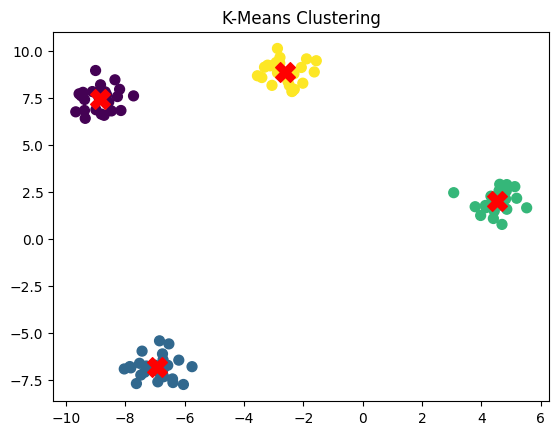

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate sample data
X, y_true = make_blobs(n_samples=100, centers=4, cluster_std=0.60, random_state=42)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X')  # cluster centers
plt.title('K-Means Clustering')
plt.show()

In [9]:
X

array([[-9.34640399,  6.41461458],
       [-6.39151686, -7.61862818],
       [-2.79088225,  9.33982215],
       [-6.0379506 , -7.72122023],
       [-8.62365534,  7.65999363],
       [-7.47394899, -7.21988823],
       [ 4.8386369 ,  2.55849676],
       [ 4.5080757 ,  2.18743723],
       [ 4.69812537,  2.55435668],
       [-3.19979377,  9.23970494],
       [-2.83582726,  9.08083968],
       [-6.74315123, -6.09582394],
       [-6.56646225, -6.70191879],
       [ 3.97607785,  1.25544571],
       [-2.06611768,  9.1171071 ],
       [-9.48086326,  7.61300636],
       [-8.67231328,  7.81983286],
       [ 4.59667276,  2.57528942],
       [-9.36864222,  7.41575798],
       [-8.55438518,  7.27982557],
       [-2.78724824,  8.73484828],
       [-8.88458878,  7.5282141 ],
       [-9.10623673,  7.83736219],
       [ 4.8567162 ,  2.89599162],
       [ 4.61838321,  2.91195588],
       [-2.78558089,  9.64855946],
       [ 3.79065639,  1.72078249],
       [-8.46292735,  6.80922838],
       [-9.42313676,

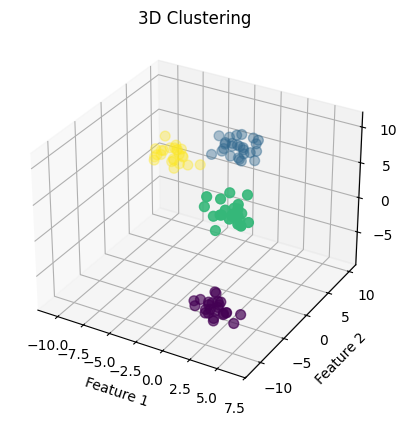

In [10]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample 3D data
X, _ = make_blobs(n_samples=100, centers=4, n_features=3, random_state=42)

# Clustering
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(X)

# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=50)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('3D Clustering')
plt.show()

In [11]:
all_ips=A.stored_self_ips+A.stored_unique_ips
output=[]
for packet in A.stored_pcap_data[:10]:
    temp=[packet.payload.src,packet.payload.dst,packet.payload.len+14]
    output.append(temp)
output

[['192.168.0.128', '192.168.0.1', 66],
 ['192.168.0.1', '192.168.0.128', 66],
 ['192.168.0.128', '192.168.0.1', 54],
 ['192.168.0.128', '192.168.0.1', 381],
 ['192.168.0.128', '192.168.0.1', 363],
 ['192.168.0.1', '192.168.0.128', 54],
 ['192.168.0.1', '192.168.0.128', 54],
 ['192.168.0.1', '192.168.0.128', 272],
 ['192.168.0.1', '192.168.0.128', 389],
 ['192.168.0.128', '192.168.0.1', 54]]

In [12]:
A.stored_pcap_data[0].payload.dst

'192.168.0.1'

In [13]:
A.stored_unique_ips

['192.168.0.1',
 '142.250.182.35',
 '35.73.6.249',
 '23.58.59.27',
 '23.212.164.233',
 '3.227.250.164',
 '3.232.144.130',
 '34.104.35.123',
 '203.171.247.224',
 '35.186.224.45',
 '20.207.73.85',
 '13.35.20.44',
 '162.159.136.234',
 '104.199.241.202',
 '199.232.103.52',
 '20.24.125.47',
 '203.171.247.10',
 '204.79.197.203',
 '23.208.65.244',
 '20.24.249.45',
 '192.168.0.16',
 '155.133.225.20',
 '35.186.224.22',
 '35.186.224.24',
 '34.120.195.249',
 '192.168.0.255',
 '199.232.102.248',
 '23.36.27.185',
 '155.133.224.2',
 '151.101.38.250',
 '199.232.102.250',
 '203.171.247.209',
 '203.171.247.219',
 '104.18.20.205',
 '54.158.57.221',
 '35.186.224.40',
 '203.171.247.208',
 '72.25.64.11',
 '203.171.247.200',
 '54.192.151.19',
 '203.171.247.202',
 '40.81.252.176',
 '185.199.108.153',
 '202.78.239.178',
 '23.36.29.241',
 '162.159.135.232',
 '185.199.108.133',
 '203.171.247.201',
 '72.25.64.32',
 '162.159.130.232',
 '162.159.134.233',
 '162.159.137.234',
 '13.35.20.120',
 '3.233.86.39',
 '23.5

In [14]:
summarized_trace=[]
pattern=re.escape('[')
for trace in outputs_trace:
    temp=[]
    for line in trace:
        match=re.match(r"\d",line.strip())
        if match:
            temp2=line.strip()[30:]
            if re.search(pattern,temp2):
                temp2=temp2[temp2.find('[')+1:temp2.find(']')]
            temp.append(temp2)
    summarized_trace.append(temp)
summarized_trace

NameError: name 'outputs_trace' is not defined

In [ ]:

# unique_ips=[]
# temp=[]
# ip=A.stored_unique_ips[1]
# response=requests.get(f"http://ip-api.com/json/{ip}")
# data=response.json()
# temp.clear()
# temp.append(ip)
# temp.append(data)
# unique_ips.append(temp)
# unique_ips